# Data Preparation

**Prepared by:** Adisorn Promkaewngarm  

# Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import data

In [ ]:
path_SET = 'https://github.com/adisorn242/2026_WQU_CapstoneProject/blob/main/SET_Index_Weekly_2010_2025.csv'
path_assets_open = 'https://github.com/adisorn242/2026_WQU_CapstoneProject/blob/main/SET100_REIT_IFF_GLD_Open_Weekly.csv'
path_assets_close = 'https://github.com/adisorn242/2026_WQU_CapstoneProject/blob/main/SET100_REIT_IFF_GLD_Close_Weekly.csv'
path_tbill = 'https://github.com/adisorn242/2026_WQU_CapstoneProject/blob/main/TBILL1M_Daily.csv'

In [ ]:
# Your original GitHub blob URLs
path_SET = 'https://github.com/adisorn242/2026_WQU_CapstoneProject/blob/main/SET_Index_Weekly_2010_2025.csv'
path_assets_open = 'https://github.com/adisorn242/2026_WQU_CapstoneProject/blob/main/SET100_REIT_IFF_GLD_Open_Weekly.csv'
path_assets_close = 'https://github.com/adisorn242/2026_WQU_CapstoneProject/blob/main/SET100_REIT_IFF_GLD_Close_Weekly.csv'
path_tbill = 'https://github.com/adisorn242/2026_WQU_CapstoneProject/blob/main/TBILL1M_Daily.csv'

# Function to convert GitHub blob URLs to Raw URLs
def to_raw(url):
    return url.replace("github.com", "raw.githubusercontent.com").replace("/blob/", "/")

# Load data using the corrected raw URLs
df_set = pd.read_csv(to_raw(path_SET), index_col=0, parse_dates=True)
df_assets_open = pd.read_csv(to_raw(path_assets_open), index_col=0, parse_dates=True)
df_assets_close = pd.read_csv(to_raw(path_assets_close), index_col=0, parse_dates=True)
df_tbill = pd.read_csv(to_raw(path_tbill), index_col=0, parse_dates=True) #Daily data

# Preprocessing T-bill data

In [ ]:
# 1. Align and clean the T-bill data
df_tbill_weekly = df_tbill.reindex(df_assets_close.index).ffill().dropna()

# 2. Convert annual percentage to weekly simple decimal rate
df_tbill_weekly_simple = df_tbill_weekly / (100 * 52)

# 3. Convert simple weekly rate to log return
# Formula: ln(1 + r)
df_tbill_log_return_weekly = np.log(1 + df_tbill_weekly_simple)

# Calculate Log returns for Assets

In [ ]:
# 1. Verification of assets consistency
# Ensure columns match in name, order, and count
columns_match = df_assets_open.columns.equals(df_assets_close.columns)
shapes_match = df_assets_open.shape == df_assets_close.shape

print(f"Asset Tickers Match: {columns_match}")
print(f"Dataframe Shapes Match: {shapes_match}")

Asset Tickers Match: True
Dataframe Shapes Match: True


In [ ]:
# 2. Calculate Log Returns with specific naming for assets
# Formula: ln(Close / Open)
df_assets_log_returns_weekly = np.log(df_assets_close / df_assets_open).loc['2010-01-04':]

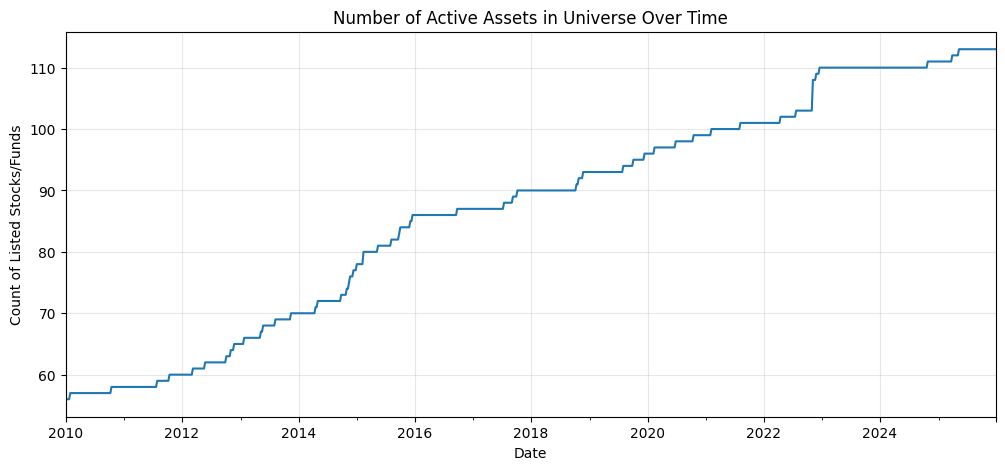

In [ ]:
# Count non-NaN values for each row (week)
active_assets_count = df_assets_log_returns_weekly.notnull().sum(axis=1)

plt.figure(figsize=(12, 5))
active_assets_count.plot(title='Number of Active Assets in Universe Over Time')
plt.ylabel('Count of Listed Stocks/Funds')
plt.grid(True, alpha=0.3)
plt.show()

# Merge T-bill with other assets

In [ ]:
# 1. Check if the indices are identical (length, values, and order)
# Using df_assets_log_returns_weekly as requested
indices_match = df_assets_log_returns_weekly.index.equals(df_tbill_log_return_weekly.index)

# 2. Detailed report of the comparison
print(f"Indices are perfectly identical: {indices_match}")
print(f"Assets Index Length: {len(df_assets_log_returns_weekly.index)}")
print(f"T-Bill Index Length: {len(df_tbill_log_return_weekly.index)}")

# 3. If they do not match, identify the specific differences
if not indices_match:
    # Check for dates in Assets but not in T-Bill
    diff_assets = df_assets_log_returns_weekly.index.difference(df_tbill_log_return_weekly.index)
    # Check for dates in T-Bill but not in Assets
    diff_tbill = df_tbill_log_return_weekly.index.difference(df_assets_log_returns_weekly.index)

    print(f"\nDates in Assets but missing in T-Bill: {len(diff_assets)}")
    if len(diff_assets) > 0:
        print(diff_assets[:5]) # Show first 5 discrepancies

    print(f"Dates in T-Bill but missing in Assets: {len(diff_tbill)}")
    if len(diff_tbill) > 0:
        print(diff_tbill[:5]) # Show first 5 discrepancies
else:
    print("\nVerification successful. Both dataframes share the exact same weekly timeline.")

Indices are perfectly identical: True
Assets Index Length: 835
T-Bill Index Length: 835

Verification successful. Both dataframes share the exact same weekly timeline.


In [ ]:
# 1. Rename the T-bill column to distinguish it from asset tickers
df_rf_ready = df_tbill_log_return_weekly.rename(columns={df_tbill_log_return_weekly.columns[0]: 'RiskFree_Rate'})

# 2. Merge Asset Log Returns and Risk-Free Log Returns
df_all_assets_log_ret = pd.concat([df_assets_log_returns_weekly, df_rf_ready], axis=1)

# 3. Final structural check
print("Merged DataFrame: df_all_assets_log_ret")
print(f"Shape: {df_all_assets_log_ret.shape}")

Merged DataFrame: df_all_assets_log_ret
Shape: (835, 114)


In [ ]:
# 4. Export with the descriptive name
if False: # Set as True to export data as csv
  df_all_assets_log_ret.to_csv("df_all_assets_log_ret_weekly.csv", index=True)

# SET Index and Feature engineering

In [ ]:
# Add return features

# 1. Initialize the feature dataframe with the target log return
df_SET_features = np.log(df_set['Close'] / df_set['Open']).to_frame(name='log_ret_t0')

# 2. Calculate Open-to-High and Open-to-Low log return
df_SET_features['SET_OH_log_ret_lag1'] = np.log(df_set['High'] / df_set['Open']).shift(1)
df_SET_features['SET_OL_log_ret_lag1'] = np.log(df_set['Low'] / df_set['Open']).shift(1)

# 3. Generate Lag 1 to Lag 52 for the 'SET_log_ret' column
for i in range(1, 53):
    df_SET_features[f'SET_log_ret_lag{i}'] = df_SET_features['log_ret_t0'].shift(i)

In [ ]:
# Add technical analysis indicators

# 1. MACD (12, 26, 9)
ema_12 = df_set['Close'].ewm(span=12, adjust=False, min_periods=12).mean()
ema_26 = df_set['Close'].ewm(span=26, adjust=False, min_periods=26).mean()
macd_line = ema_12 - ema_26
macd_histogram = macd_line - macd_line.ewm(span=9, adjust=False, min_periods=9).mean()

# 2. RSI (14-period Wilder's)
delta = df_set['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.ewm(alpha=1/14, min_periods=14, adjust=False).mean()
avg_loss = loss.ewm(alpha=1/14, min_periods=14, adjust=False).mean()
rsi = 100 - (100 / (1 + (avg_gain / avg_loss)))

# 3. Money Flow Index (MFI - 14-period)
tp = (df_set['High'] + df_set['Low'] + df_set['Close']) / 3
mf = tp * df_set['Volume']
pos_f = (mf.where(tp > tp.shift(1), 0)).rolling(window=14, min_periods=14).sum()
neg_f = (mf.where(tp < tp.shift(1), 0)).rolling(window=14, min_periods=14).sum()
mfi = 100 - (100 / (1 + (pos_f / neg_f)))

# 4. Average True Range (ATR - 14-period)
tr = pd.concat([df_set['High'] - df_set['Low'],
                abs(df_set['High'] - df_set['Close'].shift(1)),
                abs(df_set['Low'] - df_set['Close'].shift(1))], axis=1).max(axis=1)
atr = tr.rolling(window=14, min_periods=14).mean()

# 5. On-Balance Volume (OBV)
obv = (np.sign(df_set['Close'].diff()) * df_set['Volume']).fillna(0).cumsum()

# 6. Lagging and Merging (No Scaling)
# Create a temporary DataFrame for the raw TA indicators
df_temp_ta_raw = pd.DataFrame(index=df_set.index)

# Define column names and map to the calculated series
ta_data = {
    'SET_MACD_lag_1': macd_line,
    'SET_MACD_Hist_lag_1': macd_histogram,
    'SET_RSI_lag_1': rsi,
    'SET_MFI_lag_1': mfi,
    'SET_ATR_lag_1': atr,
    'SET_OBV_lag_1': obv
}

# Apply Lag 1 to all indicators
for col_name, data_series in ta_data.items():
    df_temp_ta_raw[col_name] = data_series.shift(1)

# 7. Join and cleanup
df_SET_features = df_SET_features.join(df_temp_ta_raw).dropna()

In [ ]:
# Export the SET features DataFrame to a CSV file
if False: #
  df_SET_features.to_csv("df_SET_features_weekly.csv", index=True)